# Variance and Bias Detection

These are examples of learning curves used to detect variance and bias in Pytorch models.  

## Variance Detection

Here's an example of a learning curve for a high variance Pytorch model.  The data set and neural network model architecture were suggested by [ChatGPT](https://chat.openai.com/) on 26 Feburary 2023 (using "ChatGPT Feb 13 version").

When prompted for a data set and neural network architecture that overfits the data, ChatGPT suggested two hidden layers with 1024 and 512 nodes, along with ReLU activation and dropout.  Training with 500 data points of the [MNIST data set](http://yann.lecun.com/exdb/mnist/) while using 100 epochs for training was also recommended.  Below is the implementation of that model and the resulting learning curve.

The larger number of parameters and extra layers, compared to the example in the [gpu-minibatch.ipynb](https://github.com/AlexGose/learning-curve/blob/main/notebooks/gpu_minibatch.ipynb) notebook, seemed to help induce over-fitting. However, the leveling off of the testing accuracy is clearer after increasing the number of training data points to 800.

In [ ]:
!pip list

In [59]:
# Packages to install on Google Colab
!pip install --upgrade skorch scikit-learn # need scikit-learn v1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, make_scorer, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
import matplotlib.pyplot as plt

In [61]:
train_data = torchvision.datasets.MNIST('.',train=True, download=True)
test_data = torchvision.datasets.MNIST('.',train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [62]:
height=train_data.data.shape[1]
width=train_data.data.shape[2]
num_pixels = height*width

In [63]:
X_train = train_data.data.view(-1,num_pixels).detach().numpy().astype(np.float32) / 255
X_test = test_data.data.view(-1,num_pixels).detach().numpy().astype(np.float32) / 255
X = np.vstack((X_train,X_test))

In [64]:
y_train = train_data.targets.detach().numpy().astype(np.int64)
y_test = test_data.targets.detach().numpy().astype(np.int64)
y = np.concatenate((y_train, y_test))

In [65]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [66]:
class ClassifierModule(nn.Module):
    def __init__(self, num_units1=150, num_units2=100):
        super().__init__()
        self.dense0 = nn.Linear(num_pixels, num_units1)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.output(X)
        return X

In [67]:
net = NeuralNetClassifier(
    ClassifierModule,
    module__num_units1=1024,
    module__num_units2=512,
    max_epochs=100,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=128,
    warm_start=True,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True
)

The learning curves below show a sizeable gap between the testing and training accuracy towards the right of the plot.  Due to the leveling off of both curves, more training data is unlikely to close the gap.  If the desired testing accuracy is higher than 85 percent, for example 90 percent, then this learning curve plot suggests the model has too much variance.

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3187       0.5000        1.6329  0.0564
      2        2.0759       0.4000        5.2342  0.0065
      3        5.0889       0.6500        1.2935  0.0064
      4        1.1980       0.7500        0.9578  0.0069
      5        0.8661       0.9500        0.5815  0.0065
      6        0.5052       0.9500        0.3053  0.0066
      7        0.3361       1.0000        0.1103  0.0080
      8        0.2115       1.0000        0.0612  0.0076
      9        0.1395       1.0000        0.0441  0.0073
     10        0.1655       1.0000        0.0312  0.0067
     11        0.0772       1.0000        0.0225  0.0064
     12        0.0711       1.0000        0.0081  0.0065
     13        0.1214       1.0000        0.0047  0.0066


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     14        0.0209       1.0000        0.0038  0.0071
     15        0.1485       1.0000        0.0024  0.0058
     16        0.0197       1.0000        0.0049  0.0080
     17        0.0467       1.0000        0.0266  0.0132
     18        0.0251       0.9500        0.0719  0.0071
     19        0.0731       0.9500        0.0688  0.0077
     20        0.0022       0.9500        0.0467  0.0073
     21        0.0092       1.0000        0.0080  0.0067
     22        0.0449       1.0000        0.0008  0.0069
     23        0.0049       1.0000        0.0005  0.0069
     24        0.0052       1.0000        0.0004  0.0067
     25        0.0601       1.0000        0.0141  0.0066
     26        0.1961       1.0000        0.0026  0.0066
     27        0.1711       1.0000        0.0004  0.0064
     28        0.1015       1.0000        0.0012  0.0069
     29        0.0016       1.0000        0.0051  0.0077
     30        0.0656       1.0000        0.0095  0.0102
     31        0.0098       0.9

Text(0.5, 1.0, 'Learning Curve')

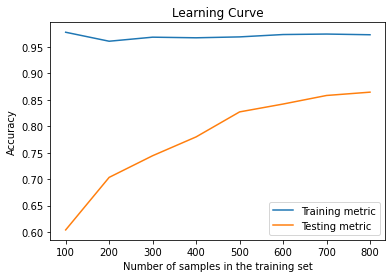

In [68]:
lcd = LearningCurveDisplay.from_estimator(net, X, y, score_type='both', 
                std_display_style=None, score_name='Accuracy', 
    scoring=make_scorer(accuracy_score),
    train_sizes=np.arange(100,801,100))
lcd.ax_.set_title('Learning Curve')

## Bias

Here's an example of a learning curve for a high bias Pytorch model.  The [data set](https://archive.ics.uci.edu/ml/datasets/mushroom) is used to predict whether mushrooms are edible or poisonous based on over 20 categorical features.  A conveniently formatted CSV file is downloaded below from the datahub.io website.

In [69]:
!wget https://datahub.io/machine-learning/mushroom/r/mushroom.csv

--2023-03-03 15:50:01--  https://datahub.io/machine-learning/mushroom/r/mushroom.csv
Resolving datahub.io (datahub.io)... 172.67.157.38, 104.21.40.221, 2606:4700:3033::6815:28dd, ...
Connecting to datahub.io (datahub.io)|172.67.157.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/mushroom/mushroom_csv/data/652524e2d0176fbc16354df92fe91fcd/mushroom_csv.csv [following]
--2023-03-03 15:50:02--  https://pkgstore.datahub.io/machine-learning/mushroom/mushroom_csv/data/652524e2d0176fbc16354df92fe91fcd/mushroom_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379652 (371K) [text/csv]
Saving to: ‘mushroom.csv.1’

mushroom.csv.1      100%[===================>] 370.75K   714KB/s    in 0.5s    

2023-03-03

In [70]:
shroom_data = pd.read_csv('mushroom.csv', low_memory=False)

In [71]:
for col in shroom_data.columns: # scale the data
    values = list(shroom_data[col].unique())
    shroom_data[col] = np.vectorize(lambda x: values.index(x))(shroom_data[col])
    if shroom_data[col].max() > 0:
        shroom_data[col] = shroom_data[col] / shroom_data[col].max()

In [72]:
X = shroom_data.iloc[:,:-1].values.astype(np.float32)
y = shroom_data.iloc[:,-1].values.astype(np.float32)

In [73]:
# only a few columns are selected from the input data
X = np.hstack((X[:,5].reshape((-1,1)), X[:,7].reshape((-1,1)), X[:,17].reshape((-1,1))))

In [74]:
num_cols = X.shape[1]
num_cols

3

In [75]:
class MushroomClassifier(nn.Module):
    def __init__(self, num_units=5):
        super().__init__()
        self.dense0 = nn.Linear(num_cols, num_units)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(num_units,10)
        self.output = nn.Linear(10,1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.output(X)
        return X

In [76]:
net = NeuralNetBinaryClassifier(
    MushroomClassifier,
    module__num_units=20,
    max_epochs=20,
    optimizer=torch.optim.Adam,
    device='cuda',
    batch_size=50,
    warm_start=True,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True
)

In the learning curves below, the training metric is no longer decreasing towards the right of the plot.  Similarly, the test metric is relatively stable in this region as well.  This suggests additional data may not be helpful.

Suppose the desired performance is above 85% testing accuracy, then both lines end up well below this mark towards the right of the plot.  This suggests bias in the model.

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7169       1.0000        0.4696  0.0343
      2        0.3099       1.0000        0.0637  0.0322
      3        0.0809       1.0000        0.0046  0.0357
      4        0.0429       1.0000        0.0007  0.0357
      5        0.0277       1.0000        0.0002  0.0327
      6        0.0245       1.0000        0.0001  0.0398
      7        0.0133       1.0000        0.0000  0.0423
      8        0.0129       1.0000        0.0000  0.0893
      9        0.0070       1.0000        0.0000  0.0665
     10        0.0091       1.0000        0.0000  0.0667
     11        0.0096       1.0000        0.0000  0.0556
     12        0.0078       1.0000        0.0000  0.0487
     13        0.0042       1.0000        0.0000  0.0374
     14        0.0032       1.0000        0.0000  0.0372
     15        0.0094       1.0000        0.0000  0.0356
     16        0.0069       1.0

Text(0.5, 1.0, 'Learning Curve')

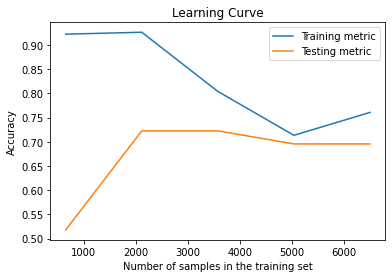

In [77]:
lcd = LearningCurveDisplay.from_estimator(net, X, y, score_type='both', 
                std_display_style=None, score_name='Accuracy', 
                scoring=make_scorer(accuracy_score))
lcd.ax_.set_title('Learning Curve')